<a href="https://colab.research.google.com/github/park-geun-hyeong/Computer_Vision/blob/main/paper/Super_Resolution/VSDR_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library import & Basic function

In [2]:
import h5py
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import torch
from torch import nn
import os
import PIL.Image as pil_image
from math import sqrt

import argparse
import copy

import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import csv



def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))


def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256. ## luminance
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256. ## color difference
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256. ## color difference
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def calc_psnr(img1, img2): ## Peak Signal-to-Noise Ratio
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2)) # 10 * log10(R^2/MSE)


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TrainDataset(Dataset):
    def __init__(self, image_dir, is_train=1, scale=4):
        super(TrainDataset, self).__init__()
        lr_dir = os.path.join(image_dir, "lr/")
        hr_dir = os.path.join(image_dir, "hr/")
        self.lr_list = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)]) ## input
        self.hr_list = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)]) ## label
        cur_len = len(self.hr_list)
        train_len = round(cur_len*0.9)

        if is_train == 1:
            self.lr_list = self.lr_list[:train_len]
            self.hr_list = self.hr_list[:train_len]
        else:
            self.lr_list = self.lr_list[train_len:]
            self.hr_list = self.hr_list[train_len:]

        self.scale = scale
        self.crop_size = 33
        self.is_train = is_train

    def __getitem__(self, idx):
        image = pil_image.open(self.lr_list[idx]).convert('RGB')
        image = np.array(image).astype(np.float32)
        ycbcr = convert_rgb_to_ycbcr(image) ## convert image from rgb to ycbcr

        lr = ycbcr[..., 0]
        lr /= 255.
        lr = torch.from_numpy(lr)
        h, w = lr.size()

        hr = pil_image.open(self.hr_list[idx]).convert('RGB')
        hr = np.array(hr).astype(np.float32)
        ycbcr = convert_rgb_to_ycbcr(hr)

        hr = ycbcr[..., 0]
        hr /= 255.
        hr = torch.from_numpy(hr)

        # random crop
        if self.is_train:
            rand_h = torch.randint(h - (self.crop_size), [1, 1])
            rand_w = torch.randint(w - (self.crop_size), [1, 1])
            lr = lr[rand_h:rand_h + self.crop_size, rand_w:rand_w + self.crop_size]
            hr = hr[rand_h:rand_h + self.crop_size, rand_w:rand_w + self.crop_size]

        lr = lr.unsqueeze(0)
        hr = hr.unsqueeze(0)
         # lr hr pair
        return lr, hr

    def __len__(self):
        return len(self.hr_list)


class TestDataset(Dataset):
    def __init__(self, image_dir, scale=4):
        super(TestDataset, self).__init__()
        lr_dir = os.path.join(image_dir, "lr/")
        self.lr_list = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)])

        self.scale = scale
        self.crop_size = 33

    def __getitem__(self, idx):
        image = pil_image.open(self.lr_list[idx]).convert('RGB')
        image = np.array(image).astype(np.float32)
        ycbcr = convert_rgb_to_ycbcr(image)

        lr = ycbcr[..., 0]
        lr /= 255.
        lr = torch.from_numpy(lr)

        lr = lr.unsqueeze(0)

        return lr

    def __len__(self):
        return len(self.lr_list)

## VSDR Model

In [3]:
class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class VSDR(nn.Module):
    def __init__(self):
        super(VSDR, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

In [5]:
scale = 4
path = '/content/drive/MyDrive/Computer_Vision/super_resolution/'
train_dir = path + 'train/'
test_dir = path + 'test/'

## Check training datasets

l_img shape :(300, 472, 3), h_img shape :(300, 472, 3)


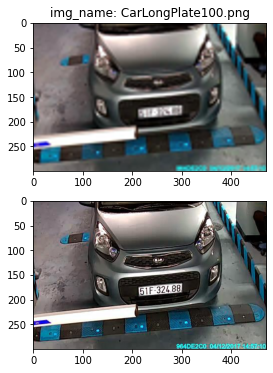

In [7]:
import cv2
import matplotlib.pyplot as plt

a = np.random.randint(len(os.listdir(train_dir+'lr')))
img_name = os.listdir(train_dir + 'lr')[a]

l_img = cv2.imread(os.path.join(train_dir+'lr' , img_name))
h_img = cv2.imread(os.path.join(train_dir+'hr', img_name))

fig,ax = plt.subplots(2,1, figsize=(8,6))
ax[0].imshow(l_img)
ax[0].set_title(f"img_name: {img_name}")
ax[1].imshow(h_img)

print(f"l_img shape :{l_img.shape}, h_img shape :{h_img.shape}")

## parameter setting

In [19]:
## Training option
model_path = path + 'model/' 
outimg_dir = path + 'restored_images/'

lr = 1e-4
batch_size = 64
num_workers = 2
seed = 123
num_epochs = 30

use_pretrain = True
pretrained = path + 'train/VSDR_best_model_PSNR_3012.pth'


if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(outimg_dir):
    os.makedirs(outimg_dir)


In [20]:
cudnn.benchmark = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
model = VSDR().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam([
                        {'params' : model.input.parameters()},
                        {'params' : model.residual_layer.parameters()},
                        {'params' : model.output.parameters(), 'lr': lr*0.1}

], lr = lr)

train_dataset = TrainDataset(train_dir, is_train=1, scale=scale)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True,
                              drop_last=True)
eval_dataset = TrainDataset(train_dir, is_train=0, scale=scale)
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

if use_pretrain is True:
    state_dict = model.state_dict()
    for n,p in torch.load(pretrained, map_location = lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)


## Training

In [ ]:
import warnings
warnings.filterwarnings('ignore')

best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0 
best_psnr = 0.0

for epoch in range(num_epochs):

    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total = (len(train_dataset) - len(train_dataset) % batch_size)) as t:
        t.set_description(f"epoch: {epoch}/{num_epochs - 1}")

        for data in train_dataloader:
            data = [i.to(device) for i in data]

            inputs, labels = data

            preds = model(inputs)
            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_postfix(f"loss = {epoch_losses.avg:.6f}")
            t.update(len(inputs))
    torch.save(model.state_dict(), f"{model_path}/epochs_{epoch}.pth")

    model.eval()
    epoch_psnr = AverageMeter()

    if (epoch + 1) % 5 == 0:
        for data in eval_dataloader:
            data = [i.to(device) for i in data]
            inputs, labels = data

            with torch.no_grad():
                preds = model(inputs).clamp(0.0, 1.0)

            epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

        print(f'eval psnr: {epoch_psnr.avg:.2f}')

        if epoch_psnr.avg > best_psnr:
            best_epoch = epoch
            best_psnr = epoch_psnr.avg
            best_weights = copy.deepcopy(model.state_dict())

print(f"best epoch: {best_epoch}, psnr: {best_psnr:.2f}")
torch.save(best_weights, os.path.join(model_path, 'best.pth'))

## Test

In [ ]:
## Test 코드
test_dataset = TestDataset(test_dir, scale=scale)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

model.eval()

img_num = len(test_dataset.lr_list)
psnr = torch.zeros(img_num)

f = open(path + 'submission.csv', 'w', newline='')
wr = csv.writer(f)
wr.writerow(['Id', 'Predicted'])

n = -1
for data in test_dataloader:
    n = n + 1
    inputs = data
    inputs = inputs.to(device)

    with torch.no_grad():
        preds = model(inputs).clamp(0.0, 1.0)

    # crop image into 20 x 20
    _, _, h, w = preds.size()
    h2 = int(h / 2)
    w2 = int(w / 2)
    preds_crop = preds[:, :, h2:h2 + 20, w2:w2 + 20] * 255

    preds_crop_array = preds_crop.reshape(20 * 20, 1)
    preds_crop_array = preds_crop_array.cpu()
    preds_crop_array = preds_crop_array.numpy()

    idx_list = list(range(n * 400 + 1, (n + 1) * 400 + 1))
    idx_list = np.array(idx_list)
   
    for ii in range(0, 400):
        wr.writerow([idx_list[ii], preds_crop_array[ii, 0]])

    preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

    image = pil_image.open(test_dataset.lr_list[n]).convert('RGB')
    image = np.array(image).astype(np.float32)
    ycbcr = convert_rgb_to_ycbcr(image)

    output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
    output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
    output = pil_image.fromarray(output)

    _, fname = os.path.split(test_dataset.lr_list[n])
    filename = "{}/{}".format(outimg_dir, fname)
    output.save(filename)